# Binary

In [1]:
import phoebe
from spice.models.binary import Binary
from spice.models.mesh_model import IcosphereModel
from spice.models.mesh_transform import transform
from spice.models.phoebe_utils import PhoebeConfig
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from spice.spectrum import simulate_observed_flux
from transformer_payne import Blackbody
import jax.numpy as jnp
from phoebe.parameters.dataset import _mesh_columns
%matplotlib inline

from jax import config
config.update('jax_platform_name', 'cpu')

## PHOEBE Configuration and Binary System Setup

In this section, we set up a binary system using PHOEBE and prepare it for integration with SPICE.

We configure the binary system with default parameters, add datasets for mesh, orbit, and light curve.

To make the lightcurve comparision as close as possible, we are going to use a simple blackbody spectrum model and disable limb darkening manually.

1. Create a default binary system
2. Define time points for computation
3. Add mesh, orbit, and light curve datasets
4. Configure limb darkening and atmosphere models
5. Run initial computation


In [2]:
from spice.models.mesh_view import get_mesh_view


def default_icosphere():
    return get_mesh_view(IcosphereModel.construct(1000, 1., 1., [5700, 0.], ['teff', 'abun']), jnp.array([0., 1., 0.]))
body1 = default_icosphere()

#body2 = transform(default_icosphere(), jnp.array([3., 0., 0.]))
body2 = default_icosphere()
binary = Binary.from_bodies(body1, body2)


/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:231: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:231: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


Let's use the simplest blackbody model.

We pass the parameter_values dict to PhoebeBinary.construct to initialize the binary system with specific parameters - since PHOEBE doesn't contain all of the parameters that can be used by the emulator, we need to add our own parameters to the mesh model. In the case of the blackbody model, this is not needed, as PHOEBE does contain temperature, but we'd need this line for e.g. abundances.


(<Figure size 1000x1200 with 2 Axes>,
 <Axes3DSubplot:xlabel='$X [R_\\odot]$', ylabel='$Y [R_\\odot]$'>)

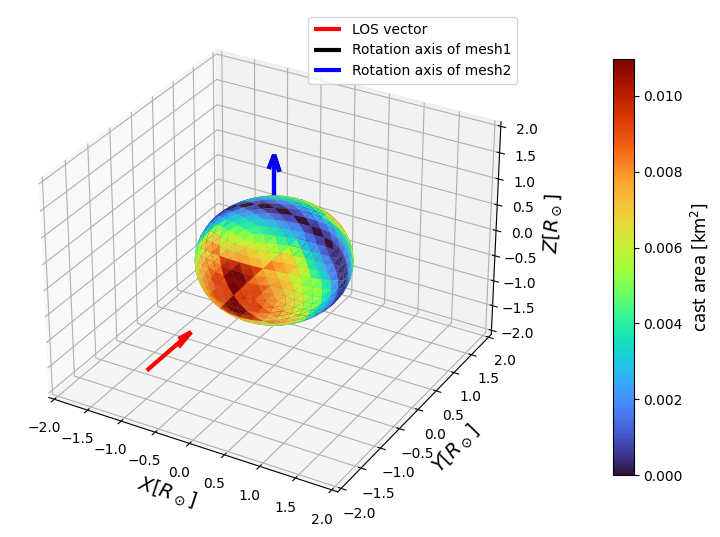

In [3]:
from spice.plots.plot_mesh import plot_3D_binary


plot_3D_binary(body1, body2, property='cast_areas')

Let's evaluate the orbit to create arrays of meshes with calculated parameters.

In [4]:
from spice.models.binary import add_orbit, evaluate_orbit_at_times

times = jnp.linspace(0.245, 0.255, 10)
# def add_orbit(binary: Binary,
#               P: float,
#               ecc: float,
#               T: float,
#               i: float,
#               omega: float,
#               Omega: float,
#               orbit_resolution_points: int) -> Binary:
binary = add_orbit(binary, 1., 0., 0., 0., 0., 0., 10)
(pb1, pb2), grid = evaluate_orbit_at_times(binary, times, n_cells=20)

In [5]:
pb1[0].center, pb2[1].center

(Array([  -4.815569, -130.10178 ,    0.      ], dtype=float32),
 Array([  3.903061, 129.94087 ,   0.      ], dtype=float32))

(<Figure size 1000x1200 with 2 Axes>,
 <Axes3DSubplot:xlabel='$X [R_\\odot]$', ylabel='$Y [R_\\odot]$'>)

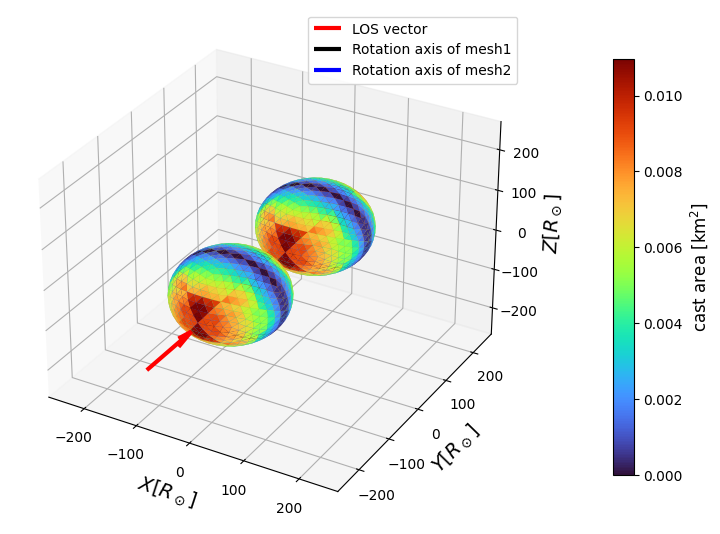

In [6]:
plot_3D_binary(pb1[0], pb2[1], property='cast_areas', scale_radius=100)

## Synthetic photometry

Let's calculate the observed flux (for the default value of $d=10$ pc) for both components. Note that we can **disable the Doppler shift**, which can be useful for comparisions with PHOEBE, as it doesn't include this effect because of computational concerns. (https://phoebe-project.org/docs/latest/tutorials/beaming_boosting)

In [7]:

from tqdm import tqdm

bb = Blackbody()
ws = np.linspace(900, 40000, 1000)
s1s = [simulate_observed_flux(bb.intensity, _pb1, np.log10(ws), disable_doppler_shift=False) for _pb1 in tqdm(pb1)]
s2s = [simulate_observed_flux(bb.intensity, _pb2, np.log10(ws), disable_doppler_shift=False) for _pb2 in tqdm(pb2)]

100%|██████████| 10/10 [00:00<00:00, 161.78it/s]


In [8]:
from spice.spectrum import AB_passband_luminosity
from spice.spectrum.filter import JohnsonV, GaiaG, Bolometric

johnsonV = JohnsonV()
lums_johnson_v = [AB_passband_luminosity(johnsonV, ws, s1[:, 0]+s2[:, 0]) for s1, s2 in zip(s1s, s2s)]
gaia_g = GaiaG()
lums_gaia_g = [AB_passband_luminosity(gaia_g, ws, s1[:, 0]+s2[:, 0]) for s1, s2 in zip(s1s, s2s)]
bolometric = Bolometric()
lums_bolometric = [AB_passband_luminosity(bolometric, ws, s1[:, 0]+s2[:, 0]) for s1, s2 in zip(s1s, s2s)]

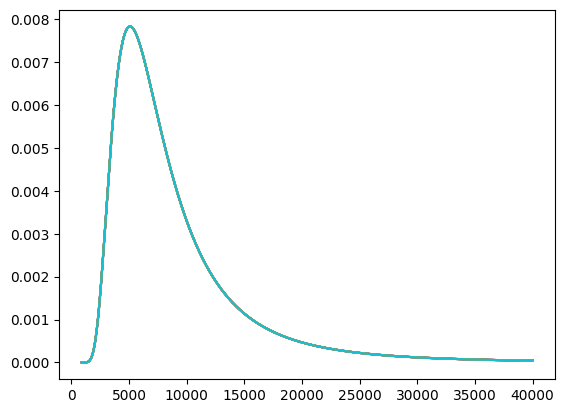

In [9]:
for _s1, _s2 in zip(s1s, s2s):
    plt.plot(ws, _s1[:, 0]+_s2[:, 0])
plt.show()

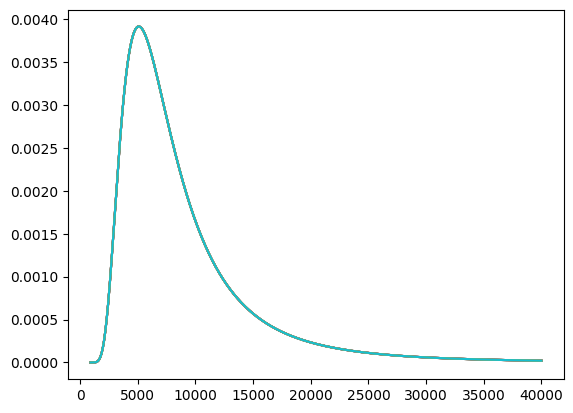

In [10]:
for s in s2s:
    plt.plot(ws, s[:, 0])
plt.show()

In [11]:
# Check if one sphere is occluded by the other in the observer's view
import numpy as np

def is_occluded(model1, model2):
    # Project centers onto the plane perpendicular to the line of sight
    projected_centers1 = model1.cast_centers
    projected_centers2 = model2.cast_centers
    
    # Calculate distances from the line of sight
    distances1 = np.linalg.norm(projected_centers1, axis=1)
    distances2 = np.linalg.norm(projected_centers2, axis=1)
    
    # Calculate distances along the line of sight
    los_distances1 = np.dot(model1.centers - model1.center, model1.los_vector)
    los_distances2 = np.dot(model2.centers - model2.center, model2.los_vector)
    
    # Check if any point of model1 is behind model2 and within its radius
    occluded = np.zeros(len(distances1), dtype=bool)
    for i, (d1, los1) in enumerate(zip(distances1, los_distances1)):
        behind = los1 > los_distances2
        within_radius = d1 < distances2[behind]
        occluded[i] = np.any(within_radius)
    
    return occluded

occluded = [is_occluded(pb1[i], pb2[i]) for i in range(len(pb1))]



In [12]:
# Find min and max occluded areas for pb1 and pb2
min_occluded_pb1 = min(np.min(pb.occluded_areas) for pb in pb1)
max_occluded_pb1 = max(np.max(pb.occluded_areas) for pb in pb1)
min_occluded_pb2 = min(np.min(pb.occluded_areas) for pb in pb2)
max_occluded_pb2 = max(np.max(pb.occluded_areas) for pb in pb2)

print(f"Occluded areas range for pb1: [{min_occluded_pb1}, {max_occluded_pb1}]")
print(f"Occluded areas range for pb2: [{min_occluded_pb2}, {max_occluded_pb2}]")

# Print overall min and max
overall_min = min(min_occluded_pb1, min_occluded_pb2)
overall_max = max(max_occluded_pb1, max_occluded_pb2)
print(f"\nOverall occluded areas range: [{overall_min}, {overall_max}]")

Occluded areas range for pb1: [0.0, 0.0]
Occluded areas range for pb2: [0.0, 0.010965690016746521]

Overall occluded areas range: [0.0, 0.010965690016746521]


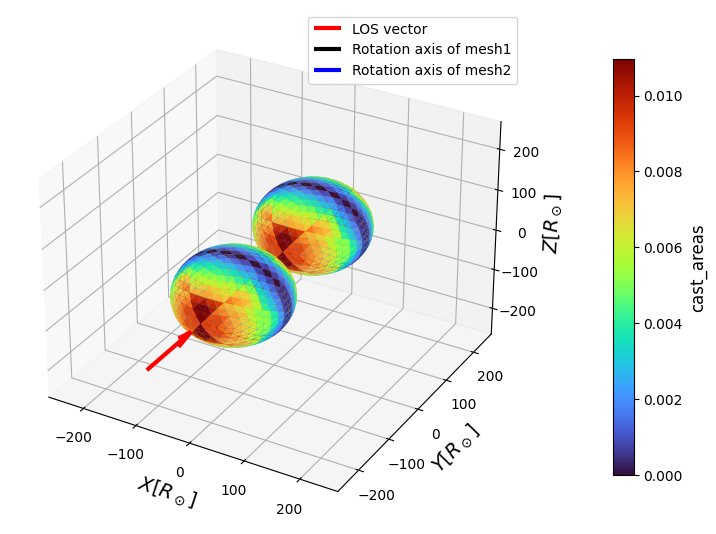

In [13]:
i = 6

fig = plt.figure(figsize=(10, 12))
spec = fig.add_gridspec(10, 12)
plot_ax = fig.add_subplot(spec[:, :11], projection='3d')

fig, ax = plot_3D_binary(pb1[i], pb2[i], scale_radius=100, property='cast_areas', cmap='turbo', property_label='cast_areas', axes=(fig, plot_ax))
plt.show()

In [14]:
# from spice.plots.plot_mesh import animate_binary

# animate_binary(pb1, pb2, 'binary.gif', property='cast_areas', cmap='turbo', property_label='cast_areas', mode='MESH', scale_radius=100)

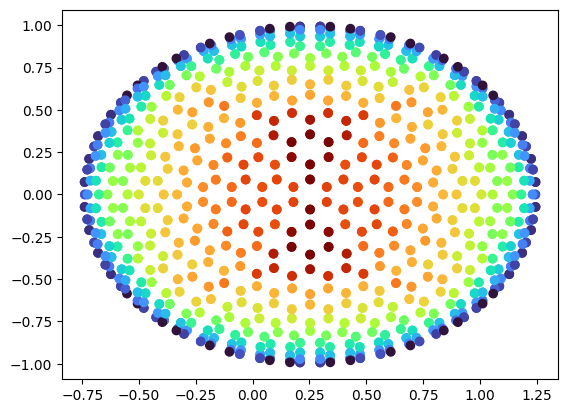

In [15]:
i = 5
#plt.scatter(pb1[i].cast_centers[:, 0], pb1[i].cast_centers[:, 1], c=pb1[i].occluded_areas, cmap='turbo')
plt.scatter(pb2[i].cast_centers[:, 0], pb2[i].cast_centers[:, 1], c=pb2[i].cast_areas, cmap='turbo')
# plt.gca().set_xlim(-200, 200)
# plt.gca().set_ylim(-200, 200)

In [16]:
# Check if occluded areas are ever larger than cast areas, only for visible areas (mu > 0)
for i in range(len(pb1)):
    # Check primary star
    visible_mask1 = pb1[i].mus > 0
    pb1_diff = pb1[i].occluded_areas[visible_mask1] - pb1[i].cast_areas[visible_mask1]
    if np.any(pb1_diff > 0):
        print(f"Time {i}: Primary star has occluded areas larger than cast areas")
        print(f"Max difference: {np.max(pb1_diff)}")
        print(f"Number of violations: {np.sum(pb1_diff > 0)}\n")
        
    # Check secondary star    
    visible_mask2 = pb2[i].mus > 0
    pb2_diff = pb2[i].occluded_areas[visible_mask2] - pb2[i].cast_areas[visible_mask2]
    if np.any(pb2_diff > 0):
        print(f"Time {i}: Secondary star has occluded areas larger than cast areas")
        print(f"Max difference: {np.max(pb2_diff)}")
        print(f"Number of violations: {np.sum(pb2_diff > 0)}\n")

print("Check complete")


Check complete


Let's see the impact of Doppler shift on this system.

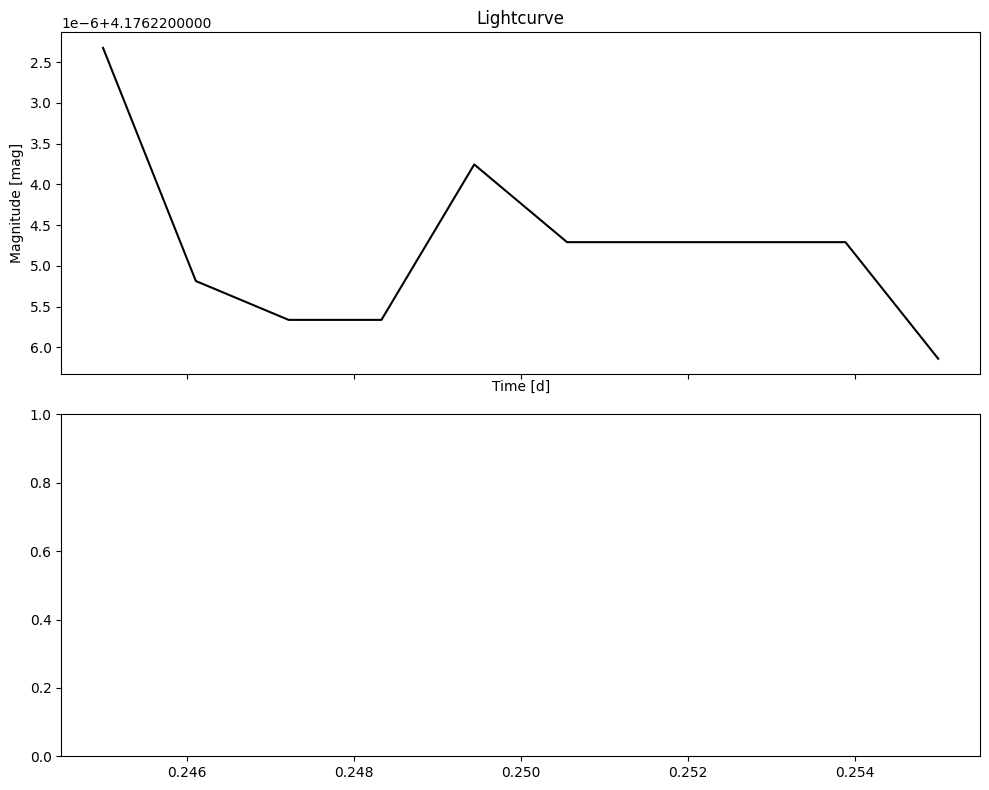

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot lightcurves
ax1.plot(times, lums_johnson_v, color='black')
ax1.invert_yaxis()
ax1.set_ylabel('Magnitude [mag]')
ax1.set_xlabel('Time [d]')
ax1.set_title('Lightcurve')

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


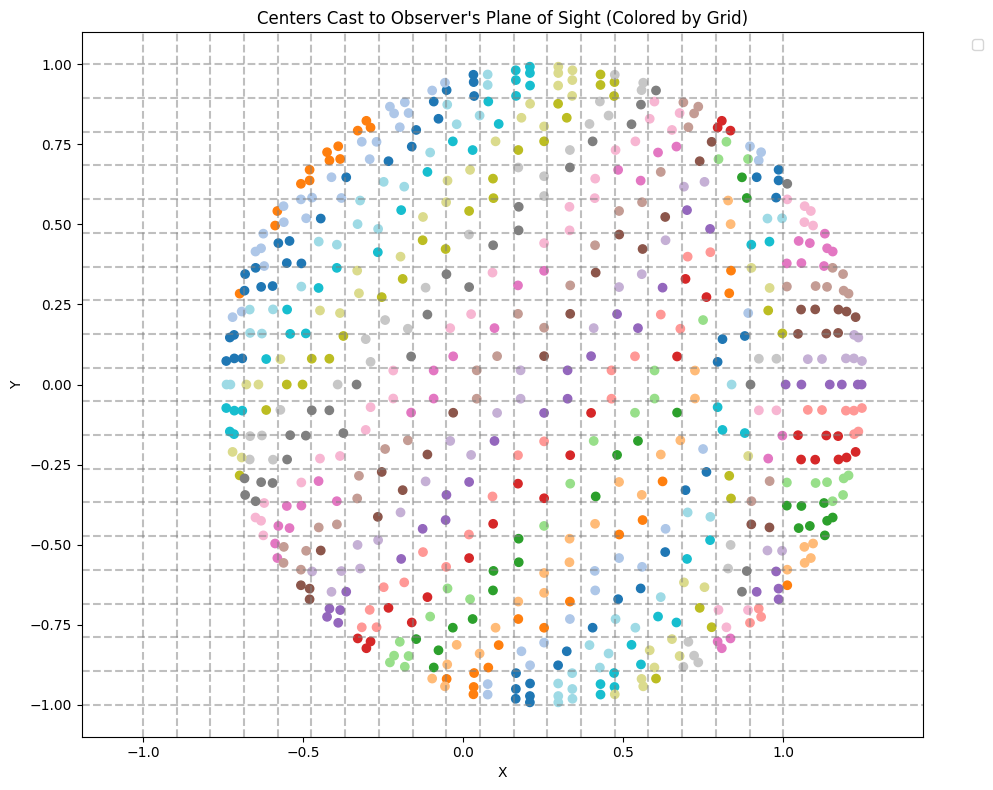

In [18]:
from functools import partial
import jax
from spice.geometry.utils import append_value_to_last_nan
from spice.models.mesh_model import MeshModel
from spice.models.mesh_view import create_grid_dictionaries, get_grid_index, get_neighbouring, total_visible_area
from spice.models.utils import cast_to_normal_plane
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

i = 5
body1, body2 = pb1[i], pb2[i]

# Create grid dictionaries
(_, grids_m1, reverse_grids_m1), (_, grids_m2, reverse_grids_m2) = create_grid_dictionaries(body1, body2, grid)
reverse_grids_m1 = jnp.nan_to_num(reverse_grids_m1, -1)
reverse_grids_m2 = jnp.nan_to_num(reverse_grids_m2, -1)
# Create a colormap
# Create a colormap for the categories in reverse_grids_m1 and reverse_grids_m2
# Convert pairs of numbers to tuples for unique categories
unique_categories = np.unique(np.vstack((reverse_grids_m1, reverse_grids_m2)), axis=0)
n_categories = len(unique_categories)
cmap = plt.get_cmap('tab20')
category_colors = {tuple(cat): cmap(i % 20) for i, cat in enumerate(unique_categories)}

# Plot the cast centers with colors based on grid allocation
plt.figure(figsize=(10, 8))

# mus1 = body1.mus > 0
# plt.scatter(body1.cast_centers[mus1, 0], body1.cast_centers[mus1, 1],
#             c=[category_colors[tuple([int(x[0]), int(x[1])])] for x in reverse_grids_m1[mus1]])

mus2 = body2.mus > 0
plt.scatter(body2.cast_centers[mus2, 0], body2.cast_centers[mus2, 1],
            c=[category_colors[tuple([int(x[0]), int(x[1])])] for x in reverse_grids_m2[mus2]])
    
for x in grid.x:
    plt.axvline(x, color='gray', linestyle='--', alpha=0.5)
for y in grid.y:
    plt.axhline(y, color='gray', linestyle='--', alpha=0.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Centers Cast to Observer\'s Plane of Sight (Colored by Grid)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [23]:
# Plot the cast centers colored by cast areas
from matplotlib.colors import LogNorm


plt.figure(figsize=(10, 8))

# Plot body 1 cast centers
mus1 = body1.mus > 0
# scatter1 = plt.scatter(body1.cast_centers[mus1, 0], body1.cast_centers[mus1, 1],
#                       c=body1.cast_areas[mus1], cmap='viridis', 
#                       label='Body 1', zorder=0)

# Plot body 2 cast centers  
mus2 = body2.mus > 0
scatter2 = plt.scatter(body2.cast_centers[mus2, 0], body2.cast_centers[mus2, 1],
                      c=body2.visible_cast_areas[mus2], cmap='turbo',
                      label='Body 2', zorder=1)

for x in grid.x:
    plt.axvline(x, color='gray', linestyle='--', alpha=0.5)
for y in grid.y:
    plt.axhline(y, color='gray', linestyle='--', alpha=0.5)
    
# Highlight points in specified region
mask = (body2.cast_centers[mus2, 0] > -0.1) & (body2.cast_centers[mus2, 0] < 0.) & \
       (body2.cast_centers[mus2, 1] > 0.4) & (body2.cast_centers[mus2, 1] < 0.6)
plt.scatter(body2.cast_centers[mus2][mask, 0], body2.cast_centers[mus2][mask, 1], 
           color='red', s=100, facecolors='none', label='Highlighted Region')


plt.colorbar(scatter2, label='Cast Area')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Centers Cast to Observer\'s Plane of Sight (Colored by Cast Area)')
plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()
